In [1]:
import latentvelo as ltv
import scanpy as sc
import scvelo as scv
import numpy as np
import torch as th
import anndata as ad

Global seed set to 0


In [2]:
adata = sc.read('../synthetic_datasets/synthetic_trifurcation.h5ad')
adata.layers['rna_velocity'] = np.array(adata.layers['rna_velocity'].todense())

milestones = adata.uns['traj_progressions']['from'].values + '->' + adata.uns['traj_progressions']['to'].values

for i in range(len(milestones)):
    
    state = milestones[i]
    
    if state == 'sA->sB':
        milestones[i] = 'A'
    
    elif state == 'sB->sC' or state == 'sC->sCmid':
        milestones[i] = 'B'
    
    elif state == 'sCmid->sD':
        milestones[i] = 'C'
    
    elif state == 'sCmid->sE':
        milestones[i] = 'D'
        
    elif state == 'sCmid->sF': 
        milestones[i] = 'E'
        
    elif state == 'sD->sEndD': 
        milestones[i] = 'F'
        
    elif state == 'sE->sEndE': 
        milestones[i] = 'G'
        
    elif state == 'sF->sEndF': 
        milestones[i] = 'H'

adata.obs['milestone'] = milestones

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


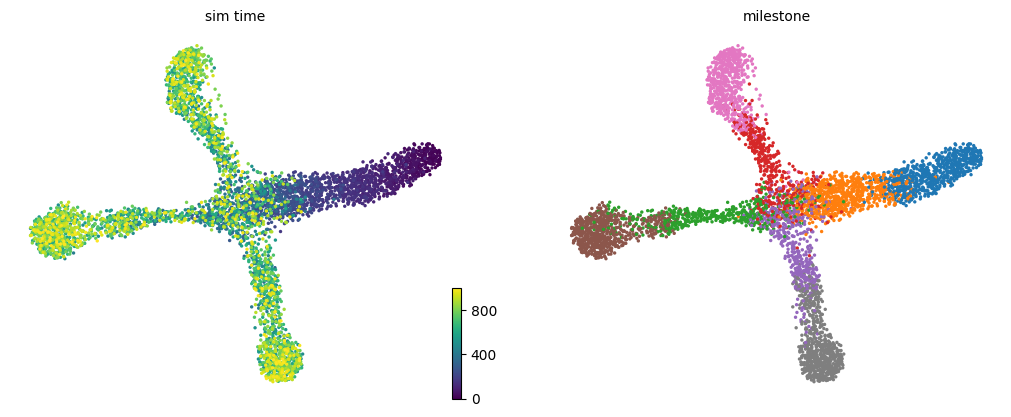

In [3]:
ltv.utils.standard_clean_recipe(adata, spliced_key='counts_spliced', unspliced_key='counts_unspliced',
                                 umap=True)
scv.pl.umap(adata, color=['sim_time', 'milestone'])

In [4]:
model = ltv.models.VAE(observed=82, latent_dim=20, zr_dim=2, h_dim=3)

In [5]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=50, name='trifurcation', grad_clip=100)

26 velocity genes used
epoch 0, full loss 130.706, val loss 58.621, recon MSE 2.893, traj MSE 0.533, reg loss -3.209
epoch 1, full loss 78.346, val loss 10.501, recon MSE 2.603, traj MSE 0.463, reg loss -3.870
epoch 2, full loss 79.005, val loss -31.950, recon MSE 2.091, traj MSE 0.557, reg loss -3.104
epoch 3, full loss 127.931, val loss -73.363, recon MSE 1.751, traj MSE 0.375, reg loss -3.522
epoch 4, full loss 215.245, val loss -104.239, recon MSE 1.512, traj MSE 0.327, reg loss -2.468
epoch 5, full loss 237.250, val loss -120.201, recon MSE 1.129, traj MSE 0.327, reg loss -2.390
epoch 6, full loss 281.438, val loss -128.799, recon MSE 0.978, traj MSE 0.321, reg loss -2.666
epoch 7, full loss 324.854, val loss -133.789, recon MSE 0.852, traj MSE 0.317, reg loss -2.568
epoch 8, full loss 362.917, val loss -135.749, recon MSE 0.799, traj MSE 0.319, reg loss -2.580
epoch 9, full loss 404.276, val loss -136.548, recon MSE 0.750, traj MSE 0.309, reg loss -2.465
epoch 10, full loss 419.3

computing velocity graph (using 12/16 cores)


  0%|          | 0/5000 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


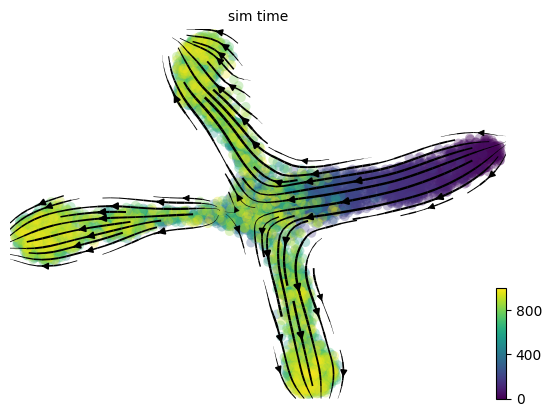

In [7]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True)

scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity', n_jobs=12)
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', color='sim_time',
                                cutoff_perc=0)

# Perform benchmark

In [8]:
adata.layers['gene_velocity'] = adata.layers['velo'].copy()

cluster_edges = [('A', 'B'),
                 ('B', 'C'),('C', 'F'),
                 ('B', 'D'), ('D', 'H'), ('E', 'H')]

ltv.ev.format_benchmark_adata(adata, latent_adata, estimated_vkey='spliced_velocity')
results = ltv.ev.benchmark_synthetic(adata, estimated_vkey='gene_velocity', 
                                      sim_vkey='rna_velocity', 
                                      basis_list=['','latent','pca','pca_10', 'pca_3','umap'],
                                      cluster_edges = cluster_edges, cluster_key='milestone', avg_velocity=True)

adata.write('../benchmark/synthetic_trajectories/fits/trifurcation_adata.h5ad')
latent_adata.write('../benchmark/synthetic_trajectories/fits/trifurcation_latent_adata.h5ad')
results.to_csv('../benchmark/synthetic_trajectories/fits/trifurcation_results_df.csv')

computing velocity embedding
    finished (0:00:02) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_pca_20', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_3', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/16 cores)


  0%|          | 0/5000 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'rna_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'rna_velocity_latent', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:02) --> added
    'rna_velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:01) --> added
    'rna_velocity_pca_20', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_3', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_umap', embedded velocity vectors (adata.obsm)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.